## Installs and imports

In [ ]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import numpy as np
from scipy.special import softmax
import pandas as pd

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv ('/content/drive/My Drive/PATH_TO_THE_DIRECTORY/filename.csv') # insert your path to the directory and the filename

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df.astype(str).applymap(lambda x: x[:514])

dataset = (df['Message'])
print (dataset.head(50))

In [ ]:
dataset = dataset.dropna().to_list()

## Model

For the github page, visit "XLM-T - A Multilingual Language Model Toolkit for Twitter", https://github.com/cardiffnlp/xlm-t

In [ ]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)
BATCH_SIZE = 1

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
config = AutoConfig.from_pretrained(MODEL) # used for id to label name
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

## Forward

In [ ]:
def forward(text, cuda=True):
  #text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [ ]:
print (np.size(dataset))

first_N_messages = dataset [:5000]
print (np.size(first_N_messages))

241441
5000


In [ ]:
dl = DataLoader(first_N_messages, batch_size=BATCH_SIZE)
all_preds = []

for idx, batch in enumerate(dl):
  print('Batch ',idx+1,' of ',len(dl))
  #text = preprocess(batch)
  text = batch
  if (text != "nan"):
    scores = forward(text, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    all_preds.extend(preds)

#print (all_preds)

In [ ]:
print (np.size(all_preds))

5000


In [ ]:
print (all_preds)

[1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 

In [ ]:
print ("(0, 1, 2) predicted scores correspond to:") 
config.id2label[0], config.id2label[1], config.id2label[2]

(0, 1, 2) predicted scores correspond to:


('Negative', 'Neutral', 'Positive')

In [ ]:
for example in range(np.size(first_N_messages)):
  pred = all_preds[example]
  print(first_N_messages[example], '--->', config.id2label[pred])

### The outout of the cell is deleted purposefully

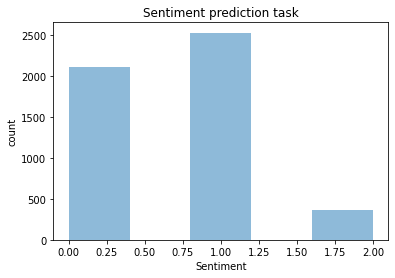

In [ ]:
from matplotlib import pyplot as plt

plt.hist(all_preds, bins=5, alpha=0.5)

plt.title('Sentiment prediction task')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()